### Data Understanding

Let’s understand what type of data we have to answer the questions made in Business understanding.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./survey_results_public20.csv', low_memory=False)
schema = pd.read_csv('./survey_results_schema20.csv')
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


Let's understand more about the data we have!

In [4]:
print('World number respondents: %s'%df.shape[0])
print('US number respondents: %s'%df.query('Country == "United States"').shape[0])

World number respondents: 64461
US number respondents: 12469


In [5]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema.QuestionText.loc[schema.Column == column_name])[0]
    return desc

for column in df.columns:
    print('{}: {}'.format(column, get_description(column)))

Respondent: Randomized respondent ID number (not in order of survey response time)
MainBranch: Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
Hobbyist: Do you code as a hobby?
Age: What is your age (in years)? If you prefer not to answer, you may leave this question blank.
Age1stCode: At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)
CompFreq: Is that compensation weekly, monthly, or yearly?
CompTotal: What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty.
ConvertedComp: Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 worki

It's possible to see we have fields like:

1. Ethnicity and Gender
2. JobSat, which indicates respondent's job satisfaction
3. ConvertedComp, which indicates respondent's annual salary
4. JobSeek, which indicates respondent's job seeking status

How many missing values have the ethnicity and gender columns between US respondents?

In [6]:
us_df = df.query('Country == "United States"')
resp_ethny = us_df['Ethnicity'].count()/us_df.shape[0]
resp_gender = us_df['Gender'].count()/us_df.shape[0]
print('Proportion of missing values in Ethnicity: %.2f'%(1-resp_ethny))
print('Proportion of missing values in Gender: %.2f'%(1-resp_gender))

Proportion of missing values in Ethnicity: 0.19
Proportion of missing values in Gender: 0.16


Let's extract the values of ethnicity and gender columns.

In [7]:
#df['Ethnicity'].value_counts()

def extract_feature_list(column):
    '''
    INPUT 
        column - a dataframe series
        
    OUTPUT
        return - a list of possible values to a given column
    '''
    attr_set = set()
    for row in column:
        if type(row) == str:
            attr_itens = row.split(';')
            for item in attr_itens:
                # Removing special characters which cause error on filter df
                scaped_item = item.replace('(', '\(').replace(')', '\)')
                attr_set.add(scaped_item)
                
    return list(attr_set)

extract_feature_list(df['Ethnicity'])

['East Asian',
 'Indigenous \\(such as Native American, Pacific Islander, or Indigenous Australian\\)',
 'Middle Eastern',
 'Multiracial',
 'South Asian',
 'Southeast Asian',
 'Black or of African descent',
 'Hispanic or Latino/a/x',
 'Biracial',
 'White or of European descent']

In [8]:
# df['Gender'].value_counts()
extract_feature_list(df['Gender'])

['Woman', 'Man', 'Non-binary, genderqueer, or gender non-conforming']

Let's create a function to understand more about the data distribution by this two features, considering just who answer about "Ethnicity" and "Gender".

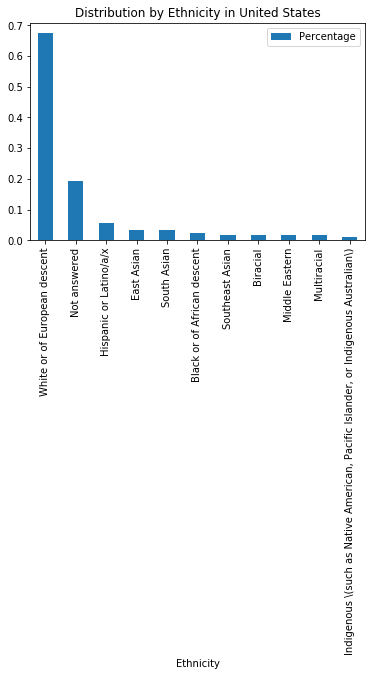

In [9]:
#filter by specific Ethnicity without nulls
#df[df['Ethnicity'].str.contains('Black or of African descent', na=False)]

def distribution_by_feature(df, feature):
    '''
    INPUT 
        df - specific dataframe;
        feature - ;
    OUTPUT
        return - a dataframe containing values represented some statistic calculated in "func" by each possible 
                 values setted in years_minority;
    '''
    items_list = extract_feature_list(df[feature])
    data = []
    
    for item in items_list:
        # na=False will ignore the missing values 
        percentage = df[df[feature].str.contains(item, na=False)].shape[0]/df.shape[0]
        data.append([item, percentage])
        
    missing_val = 1-(df[feature].count()/df.shape[0])
    data.append(['Not answered',missing_val])
    new_df = pd.DataFrame(data, columns=[feature, 'Percentage'])
    new_df = new_df.set_index(feature)
    new_df = new_df.sort_values(by='Percentage', ascending=False)
    return new_df

country = df.query('Country == "United States"')
title = 'Distribution by Ethnicity in United States'
distribution_by_feature(country, 'Ethnicity').plot(kind='bar', title=title)

In [10]:
distribution_by_feature(country, 'Ethnicity')

,Percentage
Ethnicity,
White or of European descent,0.673831
Not answered,0.192076
Hispanic or Latino/a/x,0.055177
East Asian,0.035448
South Asian,0.034004
Black or of African descent,0.024942
Southeast Asian,0.017804
Biracial,0.017002
Middle Eastern,0.016361


How is the distribution by gender in US?

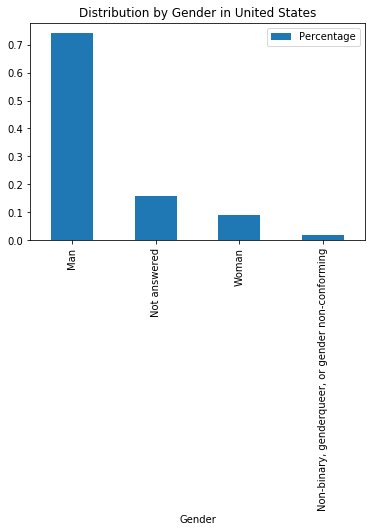

In [11]:
country = df.query('Country == "United States"')
title = 'Distribution by Gender in United States'
distribution_by_feature(country, 'Gender').plot(kind='bar', title=title)

In [12]:
distribution_by_feature(country, 'Gender')

,Percentage
Gender,
Man,0.739995
Not answered,0.158714
Woman,0.091507
"Non-binary, genderqueer, or gender non-conforming",0.017804


Has it always been this way? What are the distributions by these categories in the last few years? 

In [13]:
df18 = pd.read_csv('./survey_results_public18.csv', low_memory=False)
schema18 = pd.read_csv('./survey_results_schema18.csv')
df18.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [14]:
# schema18.head()

for column in df18.columns:
    print('{}: {}'.format(column, get_description(column, schema18)))

Respondent: Randomized respondent ID number (not in order of survey response time)
Hobby: Do you code as a hobby?
OpenSource: Do you contribute to open source projects?
Country: In which country do you currently reside?
Student: Are you currently enrolled in a formal, degree-granting college or university program?
Employment: Which of the following best describes your current employment status?
FormalEducation: Which of the following best describes the highest level of formal education that you’ve completed?
UndergradMajor: You previously indicated that you went to a college or university. Which of the following best describes your main field of study (aka 'major')
CompanySize: Approximately how many people are employed by the company or organization you work for?
DevType: Which of the following describe you? Please select all that apply.
YearsCoding: Including any education, for how many years have you been coding?
YearsCodingProf: For how many years have you coded professionally (as 

It seems like we have the same fields, but some of them are using a different feature name.

1. RaceEthnicity seems to express the same value of Ethnicity;
2. JobSatisfaction seems to express the same value of JobSat;
3. JobSearchStatus seems to express the same value of JobSeek;
4. ConvertedSalary seems to be the same that ConvertedComp;

Gender continues to be the same.

In [15]:
us_df = df18.query('Country == "United States"')
print('Number of respondents world in 2018: %s'%df18.shape[0])
print('Number of respondents US in 2018: %s'%us_df.shape[0])

resp_ethny = us_df['RaceEthnicity'].count()/us_df.shape[0]
resp_gender = us_df['Gender'].count()/us_df.shape[0]
print('Proportion of missing values in Ethnicity: %.2f'%(1-resp_ethny))
print('Proportion of missing values in Gender: %.2f'%(1-resp_gender))

Number of respondents world in 2018: 98855
Number of respondents US in 2018: 20309
Proportion of missing values in Ethnicity: 0.27
Proportion of missing values in Gender: 0.23


In [16]:
extract_feature_list(df18['RaceEthnicity'])

['Hispanic or Latino/Latina',
 'East Asian',
 'Middle Eastern',
 'South Asian',
 'Black or of African descent',
 'White or of European descent',
 'Native American, Pacific Islander, or Indigenous Australian']

In [17]:
extract_feature_list(df18['Gender'])

['Female',
 'Male',
 'Transgender',
 'Non-binary, genderqueer, or gender non-conforming']

Feature "RaceEthnicity" in the 2018 dataset have different values compared to feature "Ethnicity" in the 2020 dataset, as well as Gender feature, which has one value more in 2018 dataset compared to 2020 dataset. Let's see the 2019 dataset. 

In [18]:
df19 = pd.read_csv('./survey_results_public19.csv', low_memory=False)
schema19 = pd.read_csv('./survey_results_schema19.csv')
df19.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [19]:
for column in df19.columns:
    print('{}: {}'.format(column, get_description(column, schema19)))

Respondent: Randomized respondent ID number (not in order of survey response time)
MainBranch: Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
Hobbyist: Do you code as a hobby?
OpenSourcer: How often do you contribute to open source?
OpenSource: How do you feel about the quality of open source software (OSS)?
Employment: Which of the following best describes your current employment status?
Country: In which country do you currently reside?
Student: Are you currently enrolled in a formal, degree-granting college or university program?
EdLevel: Which of the following best describes the highest level of formal education that you’ve completed?
UndergradMajor: What was your main or most important field of study?
EduOther: Which of the following types of non-degree education have you used or participated in? Please select all that apply.
OrgSize: Approximately how many people are employed by the company or organization you work

The 2019 dataset seems to be more in aligned with 2020 dataset looking to feature names. There are all the same features:

1. Ethnicity and Gender
2. JobSat, which indicates the job satisfaction of respondent
3. ConvertedComp, which indicates the annual salary of respondent
4. JobSeek, which indicates the job seeking status of respondent

Let's extract the possible values to Ethnicity and Gender columns in 2019 dataset.

In [20]:
us_df = df19.query('Country == "United States"')
print('Number of respondents world in 2019: %s'%df19.shape[0])
print('Number of respondents US in 2019: %s'%us_df.shape[0])

resp_ethny = us_df['Ethnicity'].count()/us_df.shape[0]
resp_gender = us_df['Gender'].count()/us_df.shape[0]
print('Proportion of missing values in Ethnicity: %.2f'%(1-resp_ethny))
print('Proportion of missing values in Gender: %.2f'%(1-resp_gender))

Number of respondents world in 2019: 88883
Number of respondents US in 2019: 20949
Proportion of missing values in Ethnicity: 0.08
Proportion of missing values in Gender: 0.04


In [21]:
extract_feature_list(df19['Ethnicity'])

['Hispanic or Latino/Latina',
 'East Asian',
 'Multiracial',
 'Middle Eastern',
 'South Asian',
 'Black or of African descent',
 'Biracial',
 'White or of European descent',
 'Native American, Pacific Islander, or Indigenous Australian']

In [22]:
extract_feature_list(df19['Gender'])

['Woman', 'Man', 'Non-binary, genderqueer, or gender non-conforming']

What are the distributions by gender and ethnicity in 2018 and 2019?

In [23]:
# Distribution by gender 2018
country18 = df18.query('Country == "United States"')
distribution_by_feature(country18, 'Gender')

,Percentage
Gender,
Male,0.688414
Not answered,0.234280
Female,0.069772
"Non-binary, genderqueer, or gender non-conforming",0.010734
Transgender,0.008962


In [24]:
# Distribution by gender 2019
country19 = df19.query('Country == "United States"')
distribution_by_feature(country19, 'Gender')

,Percentage
Gender,
Man,0.849205
Woman,0.105017
Not answered,0.036851
"Non-binary, genderqueer, or gender non-conforming",0.017614


In [25]:
# Distribution by ethnicity 2018
country18 = df18.query('Country == "United States"')
distribution_by_feature(country18, 'RaceEthnicity')

,Percentage
RaceEthnicity,
White or of European descent,0.626422
Not answered,0.268305
Hispanic or Latino/Latina,0.038997
South Asian,0.037373
East Asian,0.036979
Black or of African descent,0.018317
"Native American, Pacific Islander, or Indigenous Australian",0.012211
Middle Eastern,0.010833


In [26]:
# Distribution by ethnicity 2019
country19 = df19.query('Country == "United States"')
distribution_by_feature(country19, 'Ethnicity')

,Percentage
Ethnicity,
White or of European descent,0.765860
Not answered,0.081675
Hispanic or Latino/Latina,0.058332
South Asian,0.049549
East Asian,0.046303
Black or of African descent,0.026541
Multiracial,0.022817
Middle Eastern,0.016325
Biracial,0.016325


Let's understand what are the possible values to Job Satisfaction in the three datasets.

In [86]:
# Job Satisfaction in 2018
missing_prop = 1-(country18['JobSatisfaction'].count()/country18.shape[0])
print('Proportion missing values for job satisfaction: %.4f'%missing_prop)
df18['JobSatisfaction'].value_counts()

Proportion missing values for job satisfaction: 0.2196


Moderately satisfied                  26005
Extremely satisfied                   12436
Slightly satisfied                    10012
Slightly dissatisfied                  7057
Moderately dissatisfied                6318
Neither satisfied nor dissatisfied     4966
Extremely dissatisfied                 2482
Name: JobSatisfaction, dtype: int64

In [84]:
# Job Satisfaction in 2019
missing_prop = 1-(country19['JobSat'].count()/country19.shape[0])
print('Proportion missing values for job satisfaction: %.4f'%missing_prop)
df19['JobSat'].value_counts()

Proportion missing values for job satisfaction: 0.1601


Slightly satisfied                    24207
Very satisfied                        22452
Slightly dissatisfied                 10752
Neither satisfied nor dissatisfied     8720
Very dissatisfied                      4857
Name: JobSat, dtype: int64

In [83]:
# Job Satisfaction in 2020
missing_prop = 1-(country['JobSat'].count()/country.shape[0])
print('Proportion missing values for job satisfaction: %.4f'%missing_prop)
df['JobSat'].value_counts()

Proportion missing values for job satisfaction: 0.2196


Very satisfied                        14611
Slightly satisfied                    13930
Slightly dissatisfied                  7124
Neither satisfied nor dissatisfied     5783
Very dissatisfied                      3746
Name: JobSat, dtype: int64

In the 2018 dataset, Stackoverflow used 7 scales of “Job Satisfaction”, whereas in the following years they used 5 scales. Let's understand more about how the current job seeking status of the respondents are presented.

In [80]:
# JobSeek in 2018
missing_prop = 1-(country18['JobSearchStatus'].count()/country18.shape[0])
print('Proportion missing values for job seeking status: %.4f'%missing_prop)
df18['JobSearchStatus'].value_counts()

Proportion missing values for job seeking status: 0.1282


I’m not actively looking, but I am open to new opportunities    47556
I am not interested in new job opportunities                    19296
I am actively looking for a job                                 12636
Name: JobSearchStatus, dtype: int64

In [78]:
# JobSeek in 2019
missing_prop = 1-(country19['JobSeek'].count()/country19.shape[0])
print('Proportion missing values for job seeking status: %.4f'%missing_prop)
df19['JobSeek'].value_counts()

Proportion missing values for job seeking status: 0.0816


I’m not actively looking, but I am open to new opportunities    47260
I am not interested in new job opportunities                    21080
I am actively looking for a job                                 12215
Name: JobSeek, dtype: int64

In [77]:
# JobSeek in 2020
missing_prop = 1-(country['JobSeek'].count()/country.shape[0])
print('Proportion missing values for job seeking status: %.4f'%missing_prop)
df['JobSeek'].value_counts()

Proportion missing values for job seeking status: 0.1451


I’m not actively looking, but I am open to new opportunities    29776
I am not interested in new job opportunities                    13001
I am actively looking for a job                                  8950
Name: JobSeek, dtype: int64

Although the 2018 dataset presents a different data column name, the possible values are all the same in the three datasets. But a person who is actively looking for a job is not necessarily unemployed. Let's see what employment fields have.

In [74]:
# Employment status in 2020
missing_prop = 1-(country['Employment'].count()/country.shape[0])
print('Proportion missing values for employment status: %.4f'%missing_prop)
df['Employment'].value_counts()

Proportion missing values for employment status: 0.0042


Employed full-time                                      45270
Student                                                  7787
Independent contractor, freelancer, or self-employed     5672
Not employed, but looking for work                       2343
Employed part-time                                       2217
Not employed, and not looking for work                    322
Retired                                                   243
Name: Employment, dtype: int64

In [75]:
# Employment status in 2019
missing_prop = 1-(country19['Employment'].count()/country19.shape[0])
print('Proportion missing values for employment status: %.4f'%missing_prop)
df19['Employment'].value_counts()

Proportion missing values for employment status: 0.0137


Employed full-time                                      64440
Independent contractor, freelancer, or self-employed     8511
Not employed, but looking for work                       5600
Employed part-time                                       4469
Not employed, and not looking for work                   3803
Retired                                                   358
Name: Employment, dtype: int64

In [76]:
# Employment status in 2018
missing_prop = 1-(country18['Employment'].count()/country18.shape[0])
print('Proportion missing values for employment status: %.4f'%missing_prop)
df18['Employment'].value_counts()

Proportion missing values for employment status: 0.0178


Employed full-time                                      70495
Independent contractor, freelancer, or self-employed     9282
Not employed, but looking for work                       5805
Employed part-time                                       5380
Not employed, and not looking for work                   4132
Retired                                                   227
Name: Employment, dtype: int64

We have a lot of missing values. The strategy used to clean the data will be to use just the rows, which have all study variables answered.

In [96]:
sample = df18.query('Country == "United States" & RaceEthnicity == RaceEthnicity & Gender == Gender & JobSatisfaction == JobSatisfaction & ConvertedSalary == ConvertedSalary & JobSearchStatus == JobSearchStatus')
print('Total clean sample 2018: %s'%sample.shape[0])

Total clean sample 2018: 11402


In [98]:
sample = df19.query('Country == "United States" & Ethnicity == Ethnicity & Gender == Gender & JobSat == JobSat & ConvertedComp == ConvertedComp & JobSeek == JobSeek')
print('Total clean sample 2019: %s'%sample.shape[0])

Total clean sample 2019: 14151


In [99]:
sample = df.query('Country == "United States" & Ethnicity == Ethnicity & Gender == Gender & JobSat == JobSat & ConvertedComp == ConvertedComp & JobSeek == JobSeek')
print('Total clean sample 2020: %s'%sample.shape[0])

Total clean sample 2020: 7312
